### Modèle de segmentation FCN pour détection contour cellule

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

##### Base de contour réaliséz par détection contour OpenCV

In [2]:
df = pd.read_csv('../files_segmentation.csv', index_col=0)

In [3]:
input_img_paths = df['file_path']

In [4]:
annotation_img_paths = df['filename'].apply(lambda file: '../images_segmentation/trimaps/'+ file.split('.')[0]+'.png')

In [5]:
IMG_SHAPE = 128
BATCH_SIZE = 32
def scale_down(img):
    image = tf.cast(img, tf.float32) / 255.0
    return image


def load_and_preprocess(img_filepath, mask_filepath):
   
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SHAPE, IMG_SHAPE], method = "nearest")

    img= scale_down(img)

    return img, mask



In [6]:
input_img_paths, annotation_img_paths = shuffle(input_img_paths, annotation_img_paths)
input_img_paths_train, annotation_img_paths_train = input_img_paths[: -300], annotation_img_paths[: -300] 
input_img_paths_test, annotation_img_paths_test = input_img_paths[-300:], annotation_img_paths[-300:]

train = tf.data.Dataset.from_tensor_slices((input_img_paths_train, annotation_img_paths_train))
test = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))

AUTO = tf.data.experimental.AUTOTUNE

train = (
    train
    .shuffle(1024)
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test = (
    test
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

###### Visualisation d'un exemple

In [7]:

def display(display_list):
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(display_list[i])
        else:
            plt.imshow(np.squeeze(display_list[i],-1), cmap = "gray")
        plt.axis('off')
    plt.show()

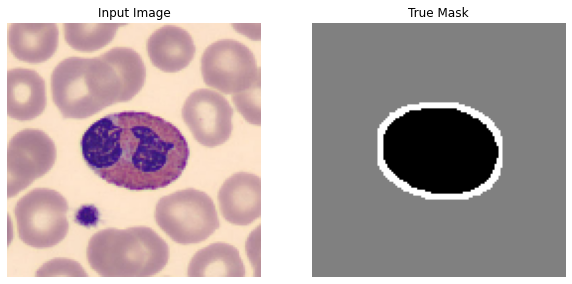

In [8]:
sample_image_batch, sample_mask_batch = next(iter(train))
sample_image, sample_mask = sample_image_batch.numpy()[0], sample_mask_batch.numpy()[0]
display([sample_image, sample_mask])


#### Définition du modèle à partir de VGG16

In [9]:

def fcn(image_size, canal_entree=3, canal_sortie=3):
    
    inputs = Input(shape=(*image_size, canal_entree), name='input')

    # Construction d'un extracteur de features VGG16 pré-entrainé (sans les dernières couches):
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # On recupere les feature maps qui sont générées par les blocs finaux:
    f3 = vgg16.get_layer('block3_pool').output  
    f4 = vgg16.get_layer('block4_pool').output  
    f5 = vgg16.get_layer('block5_pool').output  

    # On remplace les couches denses finales du VGG par des couches de convolution:
    f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
                      activation='relu')(f5)
    f5_drop1 = Dropout(0.5)(f5_conv1)
    f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
                      activation='relu')(f5_drop1)
    f5_drop2 = Dropout(0.5)(f5_conv2)
    f5_conv3 = Conv2D(filters=canal_sortie, kernel_size=1, padding='same',
                      activation=None)(f5_drop2)


    # On utilise une couche de convolution transposée afin d'augmenter la couche f5 à la taille 14x14: 
    # Ceci permet de fusionner f5 et f4_conv1 (qui est la transformation de f4 en couche de convolution):
    f5_conv3_x2 = Conv2DTranspose(filters=canal_sortie, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5_conv3)
    f4_conv1 = Conv2D(filters=canal_sortie, kernel_size=1, padding='same',
                      activation=None)(f4)

    # La fusion:
    merge1 = add([f4_conv1, f5_conv3_x2])

    # On fait de meme en augmentant la taille de la fusion precedante vers 28x28 et en la fusionnant avec un f3 convolutionné:
    merge1_x2 = Conv2DTranspose(filters=canal_sortie, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=canal_sortie, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # On utilise une autre couche de convolution transposée afin d'augmenter la taille de la feature map vers la taille qu'on veut vers la fin:
    outputs = Conv2DTranspose(filters=canal_sortie, kernel_size=16, strides=8,
                              padding='same', activation=None)(merge2)
    
    fcn_model = Model(inputs, outputs)
    return fcn_model

In [10]:
model = fcn(image_size=(128, 128))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
# Création du mask
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [12]:
# Création Callback pour stopper si pas stagnation
early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3)

In [14]:
# Entrainement du modèle
history = model.fit(train, epochs = 16,batch_size = 32, validation_data = test,callbacks=[early_stopping,reduce_lr])

Epoch 1/16
35/35 [==============================] - 806s 23s/step - loss: 0.9714 - accuracy: 0.6296 - val_loss: 0.3628 - val_accuracy: 0.8368
Epoch 2/16
35/35 [==============================] - 801s 23s/step - loss: 0.2463 - accuracy: 0.8935 - val_loss: 0.1551 - val_accuracy: 0.9456
Epoch 3/16
35/35 [==============================] - 799s 23s/step - loss: 0.1300 - accuracy: 0.9504 - val_loss: 0.1232 - val_accuracy: 0.9527
Epoch 4/16
35/35 [==============================] - 801s 23s/step - loss: 0.1100 - accuracy: 0.9561 - val_loss: 0.0980 - val_accuracy: 0.9605
Epoch 5/16
35/35 [==============================] - 821s 23s/step - loss: 0.0982 - accuracy: 0.9599 - val_loss: 0.1399 - val_accuracy: 0.9531
Epoch 6/16
35/35 [==============================] - 804s 23s/step - loss: 0.1630 - accuracy: 0.9416 - val_loss: 0.1172 - val_accuracy: 0.9537
Epoch 7/16
35/35 [==============================] - 818s 23s/step - loss: 0.1045 - accuracy: 0.9567 - val_loss: 0.0966 - val_accuracy: 0.9597
Epoch 

In [16]:
model.save('segmentation_fcn')

INFO:tensorflow:Assets written to: segmentation_fcn\assets


In [24]:
# Entrainement du modèle 2ème passage
history = model.fit(train, epochs = 16,batch_size = 32, validation_data = test,callbacks=[early_stopping,reduce_lr])

Epoch 1/16
35/35 [==============================] - 839s 24s/step - loss: 0.0453 - accuracy: 0.9842 - val_loss: 0.0509 - val_accuracy: 0.9831
Epoch 2/16
35/35 [==============================] - 801s 23s/step - loss: 0.0464 - accuracy: 0.9833 - val_loss: 0.0544 - val_accuracy: 0.9816
Epoch 3/16
35/35 [==============================] - 809s 23s/step - loss: 0.0465 - accuracy: 0.9831 - val_loss: 0.0497 - val_accuracy: 0.9842
Epoch 4/16
35/35 [==============================] - 880s 25s/step - loss: 0.0440 - accuracy: 0.9851 - val_loss: 0.0494 - val_accuracy: 0.9828
Epoch 5/16
35/35 [==============================] - 860s 25s/step - loss: 0.0441 - accuracy: 0.9843 - val_loss: 0.0547 - val_accuracy: 0.9800
Epoch 6/16
35/35 [==============================] - 976s 28s/step - loss: 0.0435 - accuracy: 0.9842 - val_loss: 0.0636 - val_accuracy: 0.9782
Epoch 7/16
35/35 [==============================] - 812s 23s/step - loss: 0.0473 - accuracy: 0.9830 - val_loss: 0.0512 - val_accuracy: 0.9823
Epoch 

In [25]:
model.save('segmentation_fcn')

INFO:tensorflow:Assets written to: segmentation_fcn\assets


In [26]:
def show_predictions_dataset(dataset,  model, num=1):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

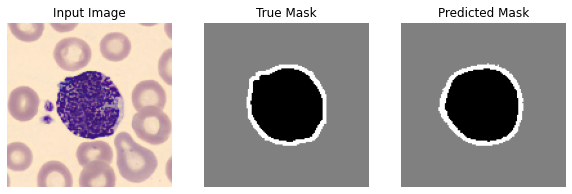

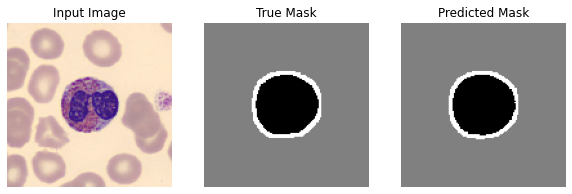

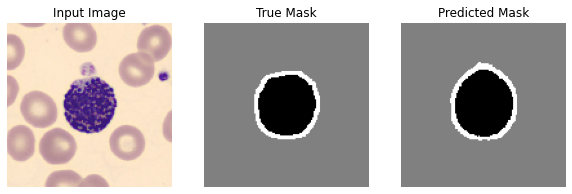

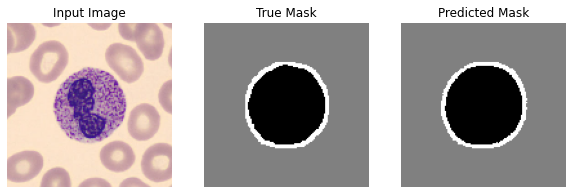

In [27]:
show_predictions_dataset(test, model, 4)

#### Prédictions image hors dataset avec globules rouges agglomérés à la cellule

In [19]:

def load_and_preprocess_img(img_filepath):  
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])
    img= scale_down(img)
    return img

In [20]:
def show_cells(list_path,  model):
    plt.figure(figsize=(20, 5))
    for i in range(len(list_path)):
        img_path = list_path[i]
        plt.subplot(1, len(list_path), i+1)
        img = load_and_preprocess_img(img_path)
        pred_mask = model.predict(tf.expand_dims(img, axis=0))
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        cell = img.copy()
        w = cell.shape[0]
        h = cell.shape[1]
        pred_mask = tf.image.resize(create_mask(pred_mask),(w, h)).numpy().reshape(w,h).astype('uint8')
        cell[ pred_mask !=0 ] = 0
        plt.imshow(cell)
        plt.axis('off')
    plt.show()

In [21]:
imgs = ['BA_18130766.jpg','BNE_596329.jpg','BA_426545.jpg','EO_780772.jpg'
           ]
data = pd.read_csv('../base_10_class.csv', index_col=0)

In [22]:
imgs_path = data[data['filename'].isin(imgs)]['file_path']

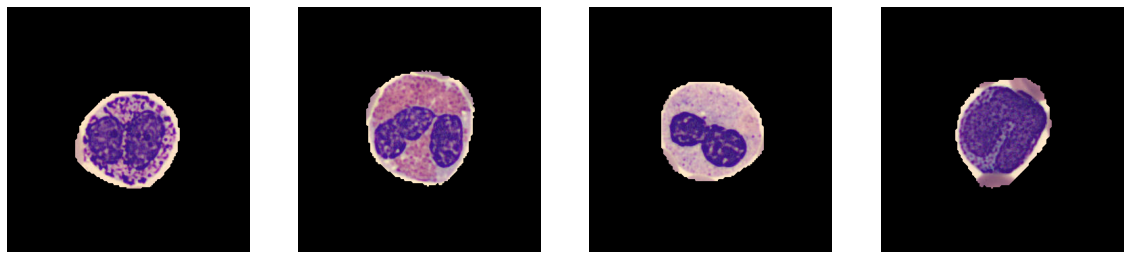

In [28]:
show_cells(imgs_path.values, model)

> Bon résultat de détourage de la cellule malgré les globules rouges agglomérés